## Wavefile Read/Write

Open and read a wavefile

In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt

signal_input_file_path = './electric_guitar_sample.wav'
signal_output_file_path = './outputs/unaltered_output.wav'

class Audio_Signal:
    def __init__(self, input_file_path, output_file_path):
        self.input_file_path = input_file_path
        self.output_file_path = output_file_path

    def load_audio(self):
        audio_signal = wave.open(self.input_file_path, 'r')
        
        self.frame_count = audio_signal.getnframes()
        self.channel_count = audio_signal.getnchannels()
        self.sample_width = audio_signal.getsampwidth()
        self.sample_rate = audio_signal.getframerate()
        self.frame_rate = audio_signal.getframerate() * 2

        self.audio_frames = audio_signal.readframes(self.frame_count)
        self.audio_frames = np.frombuffer(self.audio_frames, dtype = np.int16)
    
    def write_to_wav_file(self):
        output_file = wave.open(self.output_file_path, 'w')
        
        output_file.setnchannels(self.channel_count)
        output_file.setsampwidth(self.sample_width)
        output_file.setframerate(self.sample_rate)
        output_file.writeframes(self.audio_frames)
        
        output_file.close()
    
    def plot_audio_data(self):
        audio_length = len(self.audio_frames)

        self.time_signal = np.linspace(0, audio_length / self.frame_rate, num = audio_length)

        plt.figure()
        plt.plot(self.time_signal, self.audio_frames)
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Amplitude")

        plt.show()
    
    def get_sample_rate(self):
        pass

print("Done")

Done


In [11]:
from scipy.signal import kaiserord, firwin, freqz
from pylab import figure, plot, title, grid, xlabel, ylabel

class Filter:
    def __init__(self, filter_type='empty', nyquist_rate=22050, stop_band_attentuation_dB=10, low_transition_freq=400, high_transition_freq=4000):
        #! Adjust stop_band_attentuation_dB to control signal equalization
        self.filter_type = filter_type
        self.nyquist_rate = nyquist_rate
        self.transition_width = 200 / nyquist_rate #! Assign 5000 value to variable
        self.stop_band_attenuation_dB = stop_band_attentuation_dB
        self.low_transition_freq = low_transition_freq
        self.high_transition_freq = high_transition_freq
        
        self.filter_coefs = []

        self.calculate_filter_order()
        self.generate_filter_coefs()
    
    def calculate_filter_order(self):
        self.FIR_order, self.beta = kaiserord(self.stop_band_attenuation_dB, self.transition_width)
        self.FIR_order *= 3
        if self.FIR_order % 2 == 0:
            self.FIR_order += 1
    
    def generate_filter_coefs(self):
        if self.filter_type == "low":
            self.generate_lowfreq_filter()
        elif self.filter_type == "mid":
            self.generate_midfreq_filter()
        elif self.filter_type == "high":
            self.generate_highfreq_filter()
        elif self.filter_type == 'empty':
            pass
    
    def generate_lowfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.low_transition_freq, pass_zero='lowpass', fs=self.nyquist_rate*2)

    def generate_midfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, [self.low_transition_freq / self.nyquist_rate, self.high_transition_freq / self.nyquist_rate], pass_zero='bandpass')

    def generate_highfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.high_transition_freq, pass_zero='highpass', fs=self.nyquist_rate*2)

    def write_coefs_to_file(self):
        #! Not sure if this is how to change the filter coefficients in block memory
        pass

    def plot_filter(self):
        figure()
        w, h = freqz(self.filter_coefs, worN=8000)
        plot((w/np.pi)*self.nyquist_rate, np.absolute(h), linewidth=2)
        title('Filter Curves')
        xlabel("Frequency")
        ylabel("Filter Gain")
        grid(True)

print("Done")

Done


In [12]:
input_signal = Audio_Signal(signal_input_file_path, signal_output_file_path)

input_signal.load_audio()

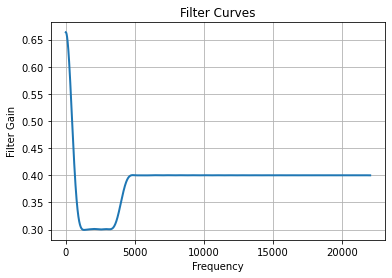

In [13]:
lowfreq_filter = Filter('low')
midfreq_filter = Filter('mid')
highfreq_filter = Filter('high')

# lowfreq_filter.plot_filter()
# midfreq_filter.plot_filter()
# highfreq_filter.plot_filter()

new_filter = Filter()
new_filter.filter_coefs = lowfreq_filter.filter_coefs * 0.6 + midfreq_filter.filter_coefs * 0.3 + highfreq_filter.filter_coefs * 0.4
new_filter.plot_filter()

In [1]:
from pynq import Overlay
import numpy as np
import random
from pynq import allocate

overlay = Overlay('/home/xilinx/pynq/overlays/equalizer/equalizer.bit')
overlay?

## Hardware Function Testing with Audio File Input

In [ ]:
dma = overlay.equalizerDMA.axi_dma_0
input_buffer = allocate(shape=(99+2+len(),), dtype=np.uint32)
output_buffer = allocate(shape=(len(),), dtype=np.uint32)

## Hardware Function Testing with Sample Input

In [6]:
dma = overlay.equalizerDMA.axi_dma_0
input_buffer = allocate(shape=(200,), dtype=np.uint32)
output_buffer = allocate(shape=(99,), dtype=np.uint32)

In [7]:
input_buffer[0] = 0xBEEF

for i in range(99):
    input_buffer[i + 1] = i

input_buffer[100] = 0xABBA

for i in range(99):
    input_buffer[i + 101] = 1

print(input_buffer)

[48879     0     1     2     3     4     5     6     7     8     9    10
    11    12    13    14    15    16    17    18    19    20    21    22
    23    24    25    26    27    28    29    30    31    32    33    34
    35    36    37    38    39    40    41    42    43    44    45    46
    47    48    49    50    51    52    53    54    55    56    57    58
    59    60    61    62    63    64    65    66    67    68    69    70
    71    72    73    74    75    76    77    78    79    80    81    82
    83    84    85    86    87    88    89    90    91    92    93    94
    95    96    97    98 43962     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1   

In [8]:
def run_kernel():
    print(0)
    dma.sendchannel.transfer(input_buffer)
    print(1)
    dma.recvchannel.transfer(output_buffer)
    print(2)
    dma.sendchannel.wait()
    print(3)
    dma.recvchannel.wait()
    print(4)

In [9]:
run_kernel()

0
1
2
3
4


In [10]:
print(output_buffer)

[  0   1   3   6  10  15  21  28  36  45  55  66  78  91 105 120 136 153
 171 190 210 231 253 276 300 325 351 378 406 435 465 496 528 528 528 528
 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528
 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528
 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528 528
 528 528 528 528 528 528 528 528 528]
